In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sc.constants as cs
from sc import payoff as po
from yq.scripts import simulation as yqsm

print(pd.__version__)

2.1.2


In [2]:
paths_arr = yqsm.read_sim_data('heston', '20231114_025704_252_0.5', pd.Timestamp('2023-08-14'), pd.Timestamp('2023-08-15'))
print(paths_arr)

[[               LONN.SE     SIKA.SE
Date                              
2023-08-15  493.026997  236.545423
2023-08-16  487.194424  216.527071
2023-08-17  465.795827  208.631344
2023-08-18  474.224037  211.820391
2023-08-21  468.032005  205.323263
...                ...         ...
2024-07-24  604.964225  340.822868
2024-07-25  598.661327  337.639795
2024-07-26  602.959821  331.328276
2024-07-29  598.110027  327.046775
2024-07-30  581.176335  329.696829

[241 rows x 2 columns],                LONN.SE     SIKA.SE
Date                              
2023-08-15  502.127864  288.576367
2023-08-16  505.158156  298.674198
2023-08-17  468.207635  291.424553
2023-08-18  491.088551  305.306027
2023-08-21  490.056340  311.112224
...                ...         ...
2024-07-24  220.381414  225.218455
2024-07-25  215.873069  218.336239
2024-07-26  210.950297  216.650850
2024-07-29  209.138938  212.954310
2024-07-30  205.917311  215.471244

[241 rows x 2 columns],                LONN.SE     SIKA.SE
Dat

In [3]:
#prep for multipath

df_sim_array_14 = []
for df in paths_arr[0]:
    df_sim_array_14.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))

df_sim_array_15 = []
for df in paths_arr[1]:
    df_sim_array_15.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))

In [4]:
# from pathlib import Path
# from yq.utils import path as yq_path
# import os
# paths_arr = yqsm.read_sim_data('gbm', '20231111_195045_022812', pd.Timestamp('2023-08-09'), pd.Timestamp('2023-08-15'))
# df_sim = paths_arr[0][0]

# fig, ax = plt.subplots(figsize=(10,6))

# hist_data = po.get_historical_assets_all()
# hist_df = hist_data[(hist_data.index >= cs.INITIAL_FIXING_DATE) 
#                            & (hist_data.index <= cs.FINAL_FIXING_DATE)]
# for asset in cs.ASSET_NAMES:
#     ax.plot(hist_df.index, hist_df[asset], alpha=0.5, label=asset)
# for col in df_sim.columns:
#     ax.plot(df_sim.index, df_sim[col], alpha=0.5, label=col)


# title_str = f"PPD: "
# plt.title(title_str)
# plt.legend(loc='upper right')
# plt.tight_layout()
# stor_dir = yq_path.get_plots_path(Path(os.getcwd()).parent)                     
# stor_dir.mkdir(parents=True, exist_ok=True)
# file_path = stor_dir.joinpath(f'test.png')
# plt.savefig(file_path, bbox_inches='tight')

   Payout       Date
0    20.0 2023-11-06
0  1000.0 2023-11-06


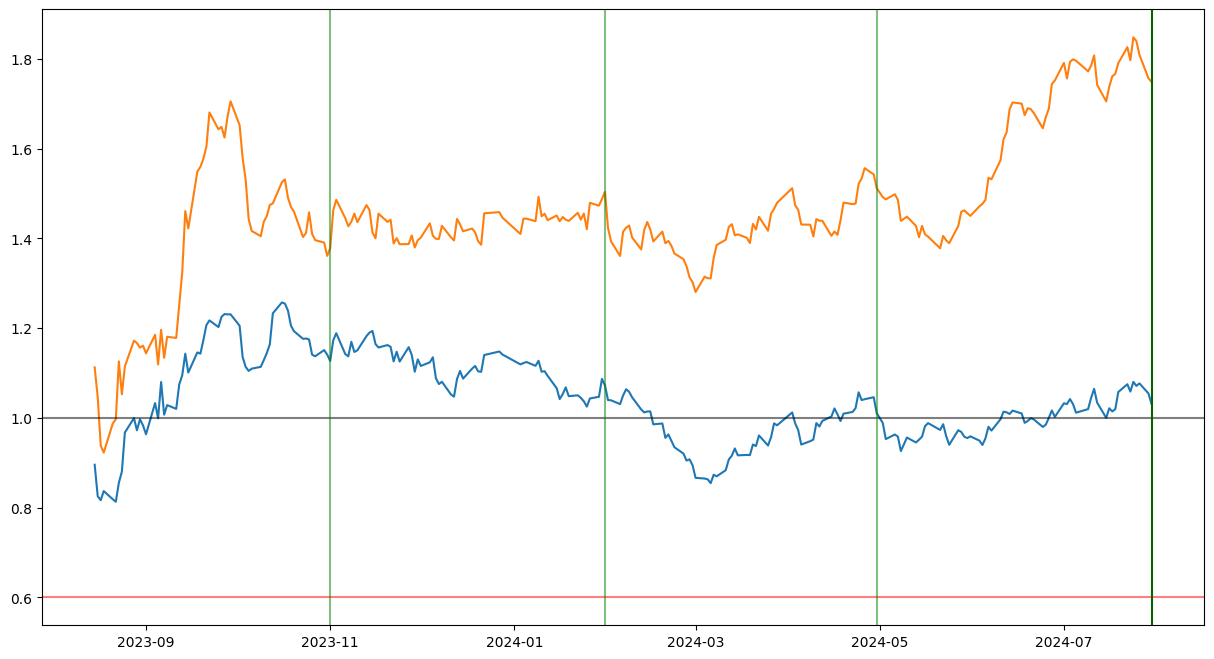

In [5]:
df_plot = paths_arr[0][5].copy(deep = True)
print(po.payouts(df_plot, barrierHit = False))
for asset in cs.ASSET_NAMES:
    df_plot[asset] = df_plot[asset] / cs.INITIAL_LEVELS[asset]
plt.figure(figsize = (15, 8))
plt.plot(df_plot)
plt.axhline(y=1, c = "black", alpha = 0.5)
plt.axhline(y = 0.6, c = "red", alpha = 0.5)
plt.axvline(x = cs.FINAL_FIXING_DATE, c = "darkgreen")
for date in cs.EARLY_REDEMPTION_OBSERVATION_DATES:
    plt.axvline(x = date, c = "green", alpha = 0.5)



In [6]:
#Entire process

first_date = pd.Timestamp('2023-08-09')
last_date = pd.Timestamp('2023-11-09')

#load simulated paths from csvs
total_data = yqsm.read_sim_data('gbm', '20231114_031302_63', first_date, last_date)

est_price = []
for single_day in total_data:
    #rename columns
    df_sim_array = []
    for df in single_day:
        df_sim_array.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))
    
    prices = po.pricing_multiple(df_sim_array)
    est_price.append(sum(prices) / len(prices))
print(est_price)




[966.2525288242681, 969.5771831186898, 977.9141941469561, 965.1193259480018, 977.2165690261478, 983.3821908437669, 948.3055622307058, 936.4226366911275, 944.0578615968185, 960.2830166955057, 944.4212962553394, 968.4644148307503, 957.9949410637631, 970.5428750889022, 968.9039494039827, 987.4616691461961, 944.6768572059665, 965.8740466653941, 980.325090908593, 991.5985033083083, 995.118667915705, 975.1165859988961, 963.6765043858064, 997.1053831077638, 997.0781209207194, 996.8162078204837, 1020.9098689104004, 1014.5841348085606, 869.9236401698383, 850.2687978061763, 872.3175688347427, 878.5499293800759, 895.5723315794494, 879.8520632867095, 863.427707261317, 872.5673950855884, 865.2288485456789, 917.4682848572749, 867.3628793672195, 865.2397072076506, 860.0253637945789, 863.130584770281, 836.8004208252339, 909.1555993411217, 907.3219442732516, 877.8303077307011, 919.3866284205053, 891.8637015857212, 871.457905598754, 725.4089263540689, 728.8259323812691, 723.5868575214325, 745.9302776197

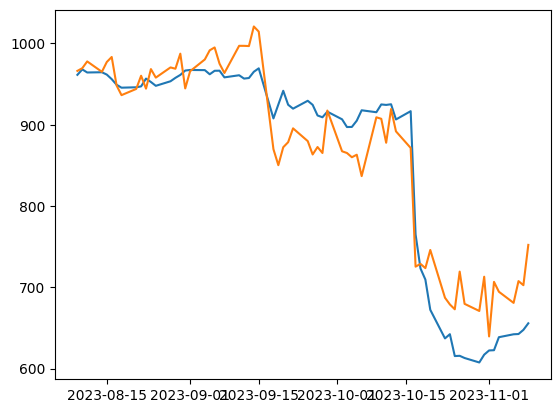

In [7]:
df_product = po.get_product_price(pd.Timestamp('2023-11-09'))
df_product = df_product.loc[first_date : last_date]
df_product['Est_Price'] = est_price

plt.plot(df_product)

In [8]:
first_date = pd.Timestamp('2023-08-09')
last_date = pd.Timestamp('2023-11-09')

total_data = yqsm.read_sim_data('gbm', '20231111_195045_022812', first_date, last_date)

df_sim = total_data[0][0].rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
df_sim_arr = total_data[0]


In [11]:
po.pricing_with_greeks_single(df_sim.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}), 0.01)

[1015.9083189521183, {'LONN.SE': [0.0, 0.0], 'SIKA.SE': [0.0, 0.0]}]

In [14]:
# entire pricing window

prices = []
deltas = {'LONN.SE': [], 'SIKA.SE': []}
gammas = {'LONN.SE': [], 'SIKA.SE': []}
for single_day in total_data:
    #rename columns
    df_sim_array = []
    for df in single_day:
        df_sim_array.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))
    
    results = po.pricing_with_greeks_multiple(df_sim_array, 0.01)
    price_sum = 0
    greeks_sum = {'LONN.SE': [0, 0], 'SIKA.SE': [0, 0]}
    for sim in results:
        price_sum += sim[0]
        for asset in cs.ASSET_NAMES:
            greeks_sum[asset][0] += sim[1][asset][0]
            greeks_sum[asset][1] += sim[1][asset][1]
    est_price = price_sum / len(results)
    for asset in cs.ASSET_NAMES:
        deltas[asset].append(greeks_sum[asset][0] / len(results))
        gammas[asset].append(greeks_sum[asset][1] / len(results))
    prices.append(est_price)


[943.1305671294414, 987.1387990143351, 956.4632859271026, 996.8638698419572, 949.6415470616221, 961.6939987333825, 948.3255022689117, 962.8791464068479, 932.1221087409256, 937.694092976038, 958.78444281706, 949.8002184982957, 964.2817608214878, 969.5070078091621, 994.8503735373484, 977.9134769297993, 1001.8849059460953, 969.295309385975, 969.5287178616703, 978.8255878593752, 987.2110177607999, 991.3985394056385, 994.7909999662472, 1004.6257434932952, 989.3467671781042, 973.2914188241058, 969.1605486509957, 997.289608600672, 891.2988414206766, 930.8944447039305, 930.3933565721538, 925.0771316568998, 913.7647320712535, 928.7230600782593, 949.9415391510669, 898.9350031094623, 927.9652791224613, 894.7620103032298, 894.2838741084441, 897.2797340967784, 893.8090657883691, 869.5307713838537, 927.5314782661205, 920.3973101318395, 900.5042741843488, 903.0550203673347, 888.8762444031231, 936.4510788191345, 911.7671613055178, 770.8207723851076, 756.780111730253, 749.9249756400258, 670.39802865774

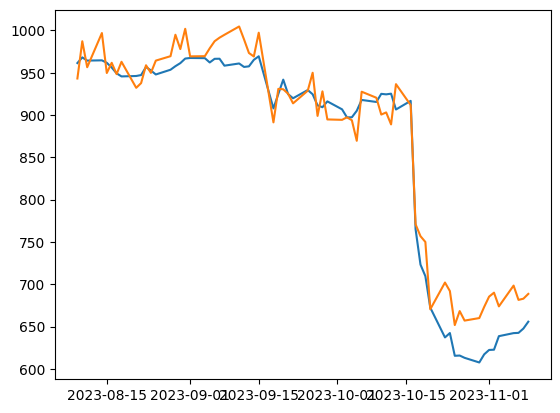

In [15]:
print(prices)
df_product = po.get_product_price(pd.Timestamp('2023-11-09'))
df_product = df_product.loc[first_date : last_date]
df_product['Est_Price'] = prices

plt.plot(df_product)

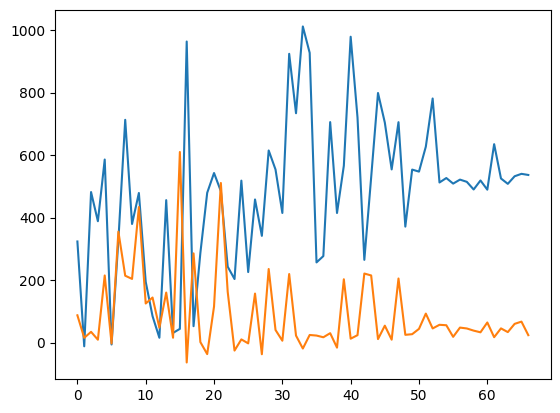

In [16]:
plt.plot(deltas['LONN.SE'])
plt.plot(deltas['SIKA.SE'])